#Attempt3:  Creating Seperate files

1. Created seperate files for model, train, test, loader

but could import only model

##Achieved 80.4% test accuracy with 65K model parameters

Remarks:
Could create seperate model file. and loaded using import

Rest files created, but last execution is not tracing those files


In [30]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# Insert the directory
import sys
sys.path.insert(0,'/content/drive/My Drive/EVA_S7_CIFAR')

In [62]:
%cd '/content/drive/My Drive/EVA_S7_CIFAR'
!pwd
!ls

/content/drive/My Drive/EVA_S7_CIFAR
/content/drive/My Drive/EVA_S7_CIFAR
cifardataloadfile.py  __pycache__		s7_cifar_modelfile.py
data		      s7_cifar_dataloadfile.py	s7_cifar_trainfile.py


In [69]:
# Import your module or file
from s7_cifar_modelfile import Net
#import cifardataloadfile  


In [68]:
# import sys
# sys.path.append('/content/drive/My Drive/EVA_S7_CIFAR')
# import s7_cifar_dataloadfile
# import s7_cifar_trainfile
# #from s7_cifar_trainfile import trainmodule

In [41]:
%matplotlib inline

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms

In [11]:
SEED = 1
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [13]:

trainset, trainloader, testset, testloader, classes = CIFAR10DataLoader()


Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



(128, 3, 32, 32)
 deer   car horse   dog


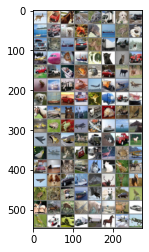

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy() 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.numpy().shape)  

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [15]:
# load to device and print model summary
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 34, 34]           2,048
        MaxPool2d-10           [-1, 32, 17, 17]               0
           Conv2d-11           [-1, 32, 17, 17]             320
           Conv2d-12           [-1, 64, 17, 17]           2,112
depthwise_separable_conv-13           [-1, 64, 17, 17]               0
             ReLU-14       

In [ ]:
from tqdm import tqdm

# train_losses = []
# test_losses = []
# train_acc = []
# test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    #train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    #train_acc.append(100*correct/processed)

In [ ]:
def test(model, device, test_loader):
    model.eval()
    #test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
           # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    #test_loss /= len(test_loader.dataset)
    #test_losses.append(test_loss)

    print('\nTest set: Accuracy: {}/{} ({:.2f}%)\n'.format( correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    #test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.7)

scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

EPOCHS = 25
for epoch in range(EPOCHS):
    #print("EPOCH:", epoch)
    print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
    train(model, device, trainloader, optimizer, epoch)
    scheduler.step()
    test(model, device, testloader)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch-0 lr: 0.1


Loss=1.0445002317428589 Batch_id=390 Accuracy=50.17: 100%|██████████| 391/391 [00:13<00:00, 28.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 5564/10000 (55.64%)

Epoch-1 lr: 0.1


Loss=0.7034409642219543 Batch_id=390 Accuracy=63.93: 100%|██████████| 391/391 [00:13<00:00, 28.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 6555/10000 (65.55%)

Epoch-2 lr: 0.1


Loss=0.8528324961662292 Batch_id=390 Accuracy=68.90: 100%|██████████| 391/391 [00:13<00:00, 28.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 6885/10000 (68.85%)

Epoch-3 lr: 0.1


Loss=0.6286733746528625 Batch_id=390 Accuracy=71.88: 100%|██████████| 391/391 [00:13<00:00, 28.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 6867/10000 (68.67%)

Epoch-4 lr: 0.1


Loss=0.7498045563697815 Batch_id=390 Accuracy=74.00: 100%|██████████| 391/391 [00:14<00:00, 27.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 7193/10000 (71.93%)

Epoch-5 lr: 0.1


Loss=0.6803346276283264 Batch_id=390 Accuracy=75.77: 100%|██████████| 391/391 [00:14<00:00, 27.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 7432/10000 (74.32%)

Epoch-6 lr: 0.1


Loss=0.6648900508880615 Batch_id=390 Accuracy=76.73: 100%|██████████| 391/391 [00:13<00:00, 28.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 7488/10000 (74.88%)

Epoch-7 lr: 0.1


Loss=0.5956546664237976 Batch_id=390 Accuracy=77.76: 100%|██████████| 391/391 [00:13<00:00, 28.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 7508/10000 (75.08%)

Epoch-8 lr: 0.1


Loss=0.7665612697601318 Batch_id=390 Accuracy=78.87: 100%|██████████| 391/391 [00:13<00:00, 29.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 7670/10000 (76.70%)

Epoch-9 lr: 0.1


Loss=0.7647866010665894 Batch_id=390 Accuracy=79.36: 100%|██████████| 391/391 [00:13<00:00, 28.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 7736/10000 (77.36%)

Epoch-10 lr: 0.010000000000000002


Loss=0.4880300462245941 Batch_id=390 Accuracy=82.87: 100%|██████████| 391/391 [00:13<00:00, 29.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 7984/10000 (79.84%)

Epoch-11 lr: 0.010000000000000002


Loss=0.3404723107814789 Batch_id=390 Accuracy=83.67: 100%|██████████| 391/391 [00:13<00:00, 29.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8030/10000 (80.30%)

Epoch-12 lr: 0.010000000000000002


Loss=0.7621990442276001 Batch_id=390 Accuracy=84.09: 100%|██████████| 391/391 [00:13<00:00, 29.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 7986/10000 (79.86%)

Epoch-13 lr: 0.010000000000000002


Loss=0.3831670880317688 Batch_id=390 Accuracy=84.26: 100%|██████████| 391/391 [00:13<00:00, 28.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8013/10000 (80.13%)

Epoch-14 lr: 0.010000000000000002


Loss=0.6286684274673462 Batch_id=390 Accuracy=84.56: 100%|██████████| 391/391 [00:13<00:00, 29.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8041/10000 (80.41%)

Epoch-15 lr: 0.010000000000000002


Loss=0.4621942639350891 Batch_id=390 Accuracy=84.73: 100%|██████████| 391/391 [00:13<00:00, 29.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 7976/10000 (79.76%)

Epoch-16 lr: 0.010000000000000002


Loss=0.3721739649772644 Batch_id=390 Accuracy=84.84: 100%|██████████| 391/391 [00:13<00:00, 29.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 7988/10000 (79.88%)

Epoch-17 lr: 0.010000000000000002


Loss=0.3602469265460968 Batch_id=390 Accuracy=85.02: 100%|██████████| 391/391 [00:13<00:00, 28.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 7974/10000 (79.74%)

Epoch-18 lr: 0.010000000000000002


Loss=0.39006978273391724 Batch_id=390 Accuracy=85.08: 100%|██████████| 391/391 [00:13<00:00, 28.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8001/10000 (80.01%)

Epoch-19 lr: 0.010000000000000002


Loss=0.35737162828445435 Batch_id=390 Accuracy=85.21: 100%|██████████| 391/391 [00:13<00:00, 29.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 7993/10000 (79.93%)

Epoch-20 lr: 0.0010000000000000002


Loss=0.6162678599357605 Batch_id=390 Accuracy=85.64: 100%|██████████| 391/391 [00:13<00:00, 29.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8007/10000 (80.07%)

Epoch-21 lr: 0.0010000000000000002


Loss=0.34582608938217163 Batch_id=390 Accuracy=85.76: 100%|██████████| 391/391 [00:13<00:00, 28.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 7978/10000 (79.78%)

Epoch-22 lr: 0.0010000000000000002


Loss=0.3539150357246399 Batch_id=390 Accuracy=85.65: 100%|██████████| 391/391 [00:13<00:00, 29.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8013/10000 (80.13%)

Epoch-23 lr: 0.0010000000000000002


Loss=0.32145825028419495 Batch_id=390 Accuracy=85.66: 100%|██████████| 391/391 [00:13<00:00, 28.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8017/10000 (80.17%)

Epoch-24 lr: 0.0010000000000000002


Loss=0.3997013568878174 Batch_id=390 Accuracy=85.94: 100%|██████████| 391/391 [00:13<00:00, 28.65it/s]



Test set: Accuracy: 8002/10000 (80.02%)



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




GroundTruth:    cat  ship  ship plane


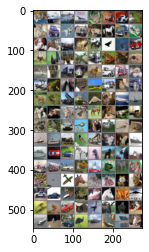

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

imagesToshow = images.detach().cpu()
# print images
imshow(torchvision.utils.make_grid(imagesToshow))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
def classwiseAccuracy(model,device,testloader, batchSize,numClasses):
  class_correct = list(0. for i in range(numClasses))
  class_total = list(0. for i in range(numClasses))
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          c = (predicted == labels).squeeze()
          for i in range(batchSize):
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1
  for i in range(numClasses):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))


In [ ]:
classwiseAccuracy(model, device, testloader,4,10)

Accuracy of plane : 79 %
Accuracy of   car : 92 %
Accuracy of  bird : 81 %
Accuracy of   cat : 50 %
Accuracy of  deer : 59 %
Accuracy of   dog : 51 %
Accuracy of  frog : 77 %
Accuracy of horse : 84 %
Accuracy of  ship : 90 %
Accuracy of truck : 82 %
